# クリーニング部

In [1]:
## クリーニング処理
def cleaning_reviews(reviews):
    dust_keywords = ['<br />', '【', '】', '(', ')','（',  '）','「', '」', '＋', '+','★', '☆', '※','~', '／', '〜', '*', '^', 'm(_ _)m', '(^^)', '(^^)', 'm(._.)m', 'ヽ=ﾟДﾟ=ﾉ']
    for key in dust_keywords:
        reviews['コメント'] = reviews['コメント'].str.replace(key, '')
    return reviews

In [2]:
##### 当メイン関数は都度実行しなくてよい(クリーニング処理をし直したい場合のみ実行)
## メイン関数
import sys
import pandas as pd

## ファイルの読込み(全件)
#shops = pd.read_csv('shops.txt', delimiter='\t')
reviews = pd.read_csv('reviews.txt', delimiter='\t')

## クリーニング
reviews = cleaning_reviews(reviews)

reviews.to_csv('reviews2.txt')

# 機械学習部

In [17]:
## Sudachiの初期化
import json
from sudachipy import tokenizer
from sudachipy import dictionary
from sudachipy import config

def init_sudachi():
    with open(config.SETTINGFILE, "r", encoding="utf-8") as f:
        settings = json.load(f)
    sudachi = dictionary.Dictionary(settings).create()
    mode = tokenizer.Tokenizer.SplitMode.C #モードC(一番長い形)に設定
    return sudachi, mode

In [18]:
## 単語の分割
import json
from sudachipy import tokenizer
from sudachipy import dictionary
from sudachipy import config

def words_tokenize(comment, sudachi, mode):
    # tokenizeで変換した結果はオブジェクトなので、surfaceメソッドで形態素解析した結果を返却
    return [m.surface() for m in sudachi.tokenize(mode, comment)]

In [19]:
## 情報確認用
def printFileInfo(reviews):

    # 点数単位の件数
    print(reviews.query('91 <= 点数 < 101')['点数'].size)
    print(reviews.query('81 <= 点数 < 91')['点数'].size)
    print(reviews.query('71 <= 点数 < 81')['点数'].size)
    print(reviews.query('61 <= 点数 < 71')['点数'].size)
    print(reviews.query('0 <= 点数 < 61')['点数'].size)

    # 点数単位のコメントの長さ
    [print(str(len(m)) + ',' + m) for m in reviews.query('91 <= 点数 < 101')['コメント']]
    [print(str(len(m)) + ',' + m) for m in reviews.query('81 <= 点数 < 91')['コメント']]
    [print(str(len(m)) + ',' + m) for m in reviews.query('71 <= 点数 < 81')['コメント']]
    [print(str(len(m)) + ',' + m) for m in reviews.query('61 <= 点数 < 71')['コメント']]
    [print(str(len(m)) + ',' + m) for m in reviews.query('0 <= 点数 < 61')['コメント']]

In [20]:
import pandas as pd

## ラベルの作成
def makeLabel(points):
    result = pd.DataFrame(points)
    for i, point in enumerate(points):
        if point >= 90:
            result.at[i, '点数'] = 0
        elif point >= 80:
            result.at[i, '点数'] = 1
        elif point >= 70:
            result.at[i, '点数'] = 2
        elif point >= 60:
            result.at[i, '点数'] = 3
        else:
            result.at[i, '点数'] = 4
    return result

Shape of data tensor:{} (108305, 100)
Shape of label tensor:{} (108305, 5)
Shape of label tensor:{} (75810, 100)
Shape of label tensor:{} (21660, 100)
Shape of label tensor:{} (10835, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1500000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 1,517,189
Trainable params: 1,517,189
Non-trainable params: 0
_________________________________________________________________
Train on 75810 samples, validate on 21660 samples
Epoch 1/30
75810/75810 [==============================] - 115s 2ms/step - loss: 1.1691 - acc: 0.4875 - val_loss: 1.1174 - val_acc: 0.4999
Epoch 2/30
75810/75

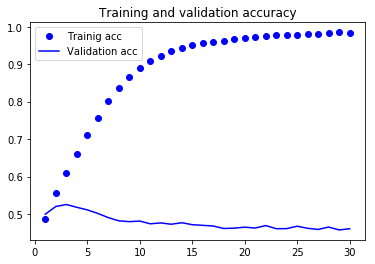

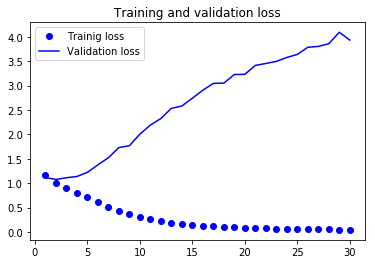

In [21]:
## メイン関数
import sys
import codecs
import random
import numpy as np
import numpy.random
import pandas as pd
import copy
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# ファイルの読込み(全件)
#reviews = pd.read_csv('reviews2.txt', delimiter=',')

# ファイルの読込み(50000件)
reviews = pd.read_csv('reviews3.txt', delimiter=',')

# ファイル情報
#printFileInfo(reviews)

## Sudachi初期化
sudachi, mode = init_sudachi()

## 単語分割
tokenized_text_list = [words_tokenize(texts, sudachi, mode) for texts in reviews['コメント']]

## 形態素解析した結果をシーケンス変換するクラスを生成(See. https://keras.io/ja/preprocessing/text/#tokenizer)
max_words = 15000 #一旦全部
tokenizer = Tokenizer(num_words=max_words)

## シーケンス変換するための事前学習
tokenizer.fit_on_texts(tokenized_text_list)

## シーケンス変換
seq = tokenizer.texts_to_sequences(tokenized_text_list)

## 入力値の整形(コメント側)
maxlen = 100 #1000を超える場合は切り捨て、1000を満たない場合はゼロパティング
data = pad_sequences(seq, maxlen=maxlen)

## 入力値の整形(点数側)
labels = makeLabel(reviews['点数'])
categorical_labels = to_categorical(labels)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}", format(data.shape)) # N件, maxlen
print("Shape of label tensor:{}", format(labels.shape)) # N件, 点数のカテゴリ化数

# 行列をランダムにシャッフル
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]

## 評価データと検算データに分割
training_samples = data.shape[0] // 100 * 70 # "//" で商だけ取得可能
validation_samples = data.shape[0] // 100 * 90 # "//" で商だけ取得可能
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:validation_samples]
y_val = labels[training_samples:validation_samples]
x_predict = data[validation_samples:]
y_predict = labels[validation_samples:]

print("Shape of label tensor:{}", format(x_train.shape)) # N件, 点数のカテゴリ化数
print("Shape of label tensor:{}", format(x_val.shape)) # N件, 点数のカテゴリ化数
print("Shape of label tensor:{}", format(x_predict.shape)) # N件, 点数のカテゴリ化数

## 学習モデルの作成
model = Sequential()
model.add(Embedding(15000, 100, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(labels.shape[1], activation='sigmoid')) #点数のカテゴリ化数
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

## 学習開始
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, validation_data=(x_val, y_val))

## モデルの保存
# model.sava('pre_trained_model.h5')

## 予測
results = model.predict(x_predict)
prediction_texts = ['90点以上', '80点以上', '70点以上', '60点以上', '60点未満']


idx = range(1, x_predict.shape[0] + 1)
col = ["predict", "real"]
b = pd.DataFrame(index = idx, columns = col)

for i, res in enumerate(results):
#    print('予測：{0}　答え：{1}'.format(prediction_texts[np.argmax(res)], prediction_texts[np.argmax(y_predict[i])]))
    b.iat[i, 0] = prediction_texts[np.argmax(res)]
    b.iat[i, 1] = prediction_texts[np.argmax(y_predict[i])]
                                   
b.to_csv('c:\\temp\\yone.txt')


## 結果のプロット
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Trainig acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Trainig loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# メモ部

In [56]:
import pandas as pd

idx = range(1, 11)
col = ["predict", "real"]
a = pd.DataFrame(index = idx, columns = col)

print(a)
a.iat[1, 0] = 1
print(a)

#a.to_csv('c:\\temp\\yone.txt')

   predict real
1      NaN  NaN
2      NaN  NaN
3      NaN  NaN
4      NaN  NaN
5      NaN  NaN
6      NaN  NaN
7      NaN  NaN
8      NaN  NaN
9      NaN  NaN
10     NaN  NaN
   predict real
1      NaN  NaN
2        1  NaN
3      NaN  NaN
4      NaN  NaN
5      NaN  NaN
6      NaN  NaN
7      NaN  NaN
8      NaN  NaN
9      NaN  NaN
10     NaN  NaN


## Special Thanks

### "LSTMを使ってテキストの多クラス分類する".CODING ECHO
https://goo.gl/MGJHTB

### "Jupyter Notebook の Tips をまとめてみた".Tech Blog
https://adtech.cyberagent.io/techblog/archives/2317

### "Jupyter 知っておくと少し便利なTIPS集".Qiita
https://qiita.com/simonritchie/items/d7dccb798f0b9c8b1ec5

### JupyterNoteBookの使い方忘れそうな部分のメモ

### Markdownモード
m  
その後、記載した後、Shift + Enterでラベルに変換  
編集したい場合は、1～6で戻るのが筋がよさげ  
rやyでも編集モードに入れるが、Markdownからコード編集モードに戻るので、数値で編集モードに入った方がよさげ